i use mpmath for calculate better Sigmoid Function
so i wrote a class (called MLP) that we can create a object of that.
this class have these parameters:
   1. NInput: number of nodes in Input Layer ( in this example we have 2 nodes for input layer)
   2. NHidden: number of nodes in one hidden layer ( in this example i use 5 nodes for one hidden layer)
   3. NLHidden: number of hidden layers ( in this example is use 2 hidden layers)
   4. NOutput: number of nodes in output layer ( in this example we have 1 node for output layer)
   5. alpha: learning rate of MLP


So First of all we initialize parameters for MLP. then we have to set weights and biases of this network
i use random.rand of numpy to set all weights and set 0 for all biases
after that i have to explain i use 2 activation function in this class :
   1. relu : this activation function for hidden layers
   2. sigmoid : this function for output layer
   
so Activation get out parameter to recognize which one we want
DeActivation is activation derivative function
FeedForward actually Get Input and fill all layers according to weights and biases
BackPropogate actually get right data ( right answer for test data ) and set again weights and biases
Train get train datas and right answer of them to train network . iterations is max epoch we can run this train algorithm . we have a max error ( 0.01) so when we rich lower that 0.01 we terminate this algorithm.
ClassifyOneOut actually say if output node of network bigger that 0.5 it's 1 and if lower than that it's 0.
we want a network not over fit to get better answer for test Data and predict better new datas.
so we have to find best number of hidden nodes and number number hidden layers for this network to get better accuracy.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from mpmath import mp

In [107]:
class MLP:
    def __init__(self,NInput,NHidden,NLHidden,NOutput,alpha):
        self.NInput=NInput
        self.NHidden=NHidden
        self.NLHidden=NLHidden
        self.NOutput=NOutput
        self.alpha=alpha
        self.Weights=np.empty(1+NLHidden,dtype=object)
        self.Biases=np.empty(NLHidden+1,dtype=object)
        self.InitWeights()
        self.InitBiases()

    def InitOneWeight(self,x,y,i):
        self.Weights[i]=np.random.rand(x,y)
    def InitWeights(self):
        self.InitOneWeight(self.NHidden,self.NInput,0)
        for i in range(1,self.NLHidden):
            self.InitOneWeight(self.NHidden,self.NHidden,i)
        self.InitOneWeight(self.NOutput,self.NHidden,self.NLHidden)
    def InitOneBias(self,x,i):
        self.Biases[i]=np.zeros(x)
    def InitBiases(self):
        for i in range(self.NLHidden):
            self.InitOneBias(self.NHidden,i)
        self.InitOneBias(self.NOutput,self.NLHidden)
    def Activation(self,x,out=False):
        if out:
            res=np.empty(len(x))
            for i in range(len(x)):
                res[i]=mp.exp(x[i])/(mp.exp(x[i])+1)
            return res
        return x*(x>0)
    def DeActivation(self,x,out=False):
        if out:
            si=self.Activation(x,True)
            return si*(1-si)
        return 1.*(x>0)
    def FeedForward(self,Input):
        self.layers=np.empty(2+self.NLHidden,dtype=object)
        self.layers[0]=Input
        self.layers[1]=np.dot(self.Weights[0],Input)+self.Biases[0]
        for i in range(1,self.NLHidden+1):
            self.layers[i+1]=np.dot(self.Weights[i],self.Activation(self.layers[i]))+self.Biases[i]
        return self.Activation(self.layers[-1],True)
    def BackPropogate(self,right):
        deta=np.empty(self.NLHidden+1,dtype=object)
        deta[-1]=np.multiply((right-self.Activation(self.layers[-1],True)),self.DeActivation(self.layers[-1],True))
        for i in range(self.NLHidden-1,-1,-1):
            deta[i]=np.multiply(np.dot(self.Weights[i+1].transpose(),deta[i+1]),self.DeActivation(self.layers[i+1]))
        self.Weights[0]+=self.alpha*np.dot(np.reshape(deta[0],[len(deta[0]),-1]),np.reshape(self.Activation(self.layers[0]),[self.NInput,-1]).transpose())
        self.Biases[0]+=self.alpha*deta[0]
        for i in range(1,self.NLHidden):
            self.Weights[i]+=self.alpha*np.dot(deta[i],self.Activation(deta[i-1]).transpose())
            self.Biases[i]+=self.alpha*deta[i]
        self.Weights[-1]+=self.alpha*np.dot(np.reshape(deta[self.NLHidden],[self.NOutput,-1]),np.reshape(self.Activation(deta[-1]),[self.NOutput,-1]).transpose())
        self.Biases[-1]+=self.alpha*deta[-1]
    def Train(self,trainData,rightData,iterations):
        start=timer()
        errors=np.empty(iterations)
        nCors=np.empty(iterations)
        for iteration in range(iterations):
            print(iteration)
            for i in range(len(trainData)):
                self.FeedForward(trainData[i])
                self.BackPropogate(rightData[i])
            errors[iteration],nCors[iteration]=self.Test(trainData,rightData)
            if errors[iteration]<=0.01:
                errors=errors[:iteration+1]
                nCors=nCors[:iteration+1]
                break
        plt.plot(np.arange(len(errors)),errors)
        plt.figure(2)
        plt.plot(np.arange(len(nCors)),nCors)
        print("End Iteration: ",len(errors))
        print("Time: ",timer()-start)
        print("Error ,  Accuracy")
        return self.Test(trainData,rightData)
    def ClassifyOneOut(self,y):
        if self.Activation([y],True)>=0.5:
            return 1
        else :
            return 0
    def Test(self,testData,rightData,out=False):
        if out:
            start=timer()
        error=0
        nCor=0
        for i in range(len(testData)):
            self.FeedForward(testData[i])
            err=self.Loss(rightData[i])
            if self.ClassifyOneOut(self.layers[-1][0])==rightData[i]:
                nCor+=1
            elif out:
                print("This Test Predict Wrong: ",i)
            error+=err
        if out:
            print("Time: ",timer()-start)
            print("Error ,  Accuracy")
        return [error/len(testData),nCor/len(testData)]
    def Loss(self,right):
        return 0.5*((right-self.Activation(self.layers[-1],True))**2).sum()

i used xor function to test MLP

In [94]:
train=np.array([[0,0,0],[1,0,1],[0,1,0],[1,1,0]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[0.02372798914326895, 1.0]

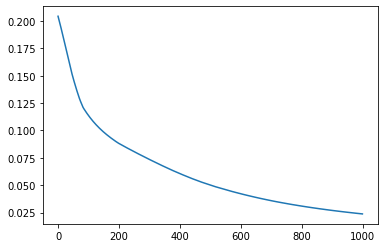

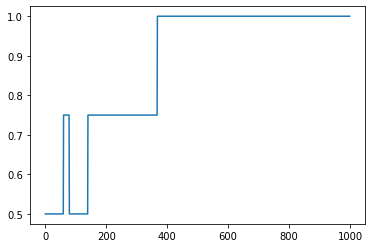

In [95]:
mlp=MLP(NInput=2,NHidden=4,NLHidden=1,NOutput=1,alpha=0.02)
mlp.Train(train[:,[0,1]],train[:,2],1000)

In [103]:
with open('train') as f:
    lines = f.readlines()
train=np.array([[float(d) for d in line.split('	')] for line in lines])
pd.DataFrame(train)

,0,1,2
0,-0.586110,-0.974014,0.0
1,-1.503634,-0.505257,0.0
2,-1.280899,-0.152307,0.0
3,-0.023598,-1.526080,0.0
4,1.336478,-1.159745,1.0
...,...,...,...
3995,0.562388,0.725981,1.0
3996,-1.399836,1.311383,0.0
3997,-0.041693,-1.372289,0.0
3998,0.237685,0.396930,1.0


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[0.03889587563078379, 0.91875]

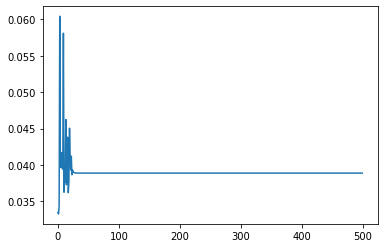

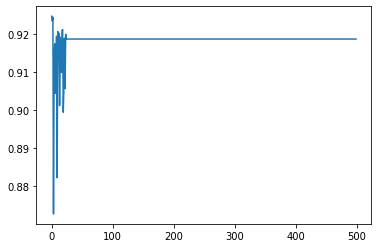

In [104]:
mlp=MLP(NInput=2,NHidden=4,NLHidden=3,NOutput=1,alpha=0.02)
mlp.Train(train[:,[0,1]],train[:,2],500)

In [105]:
with open('test') as f:
    lines = f.readlines()
test=np.array([[float(d) for d in line.split('	')] for line in lines])
pd.DataFrame(test)

,0,1,2
0,0.932599,-0.056269,1.0
1,1.060621,-0.148805,1.0
2,-0.903985,0.654105,0.0
3,-0.229572,-1.122811,0.0
4,1.640519,-0.243509,1.0
...,...,...,...
995,-1.519171,1.780392,0.0
996,-0.237250,0.032652,1.0
997,-2.668541,4.208068,0.0
998,-2.050868,-0.204963,0.0


In [106]:
mlp.Test(test[:,[0,1]],test[:,2],out=True)

This Test Predict Wrong:  [[ 0.93259865 -0.05626874]
 [ 1.06062139 -0.14880485]
 [-0.90398542  0.65410476]
 ...
 [-2.66854104  4.20806794]
 [-2.05086833 -0.2049629 ]
 [ 2.08066176 -1.05265046]] [1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0.
 1.

 [ 2.08066176 -1.05265046]] [1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 0

[0.03379173930991163, 0.929]

# Test 2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
End Iteration:  200
Time:  147.24658542199904
Error ,  Accuracy


[0.029792057992249318, 0.923]

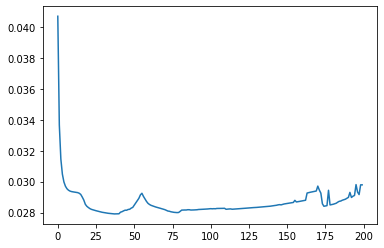

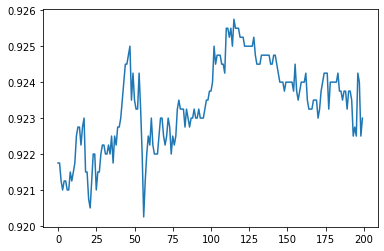

In [109]:
mlp=MLP(NInput=2,NHidden=3,NLHidden=1,NOutput=1,alpha=0.02)
mlp.Train(train[:,[0,1]],train[:,2],200)

In [110]:
mlp.Test(test[:,[0,1]],test[:,2],out=True)

This Test Predict Wrong:  6
This Test Predict Wrong:  27
This Test Predict Wrong:  52
This Test Predict Wrong:  56
This Test Predict Wrong:  59
This Test Predict Wrong:  67
This Test Predict Wrong:  74
This Test Predict Wrong:  77
This Test Predict Wrong:  96
This Test Predict Wrong:  99
This Test Predict Wrong:  101
This Test Predict Wrong:  102
This Test Predict Wrong:  122
This Test Predict Wrong:  136
This Test Predict Wrong:  149
This Test Predict Wrong:  174
This Test Predict Wrong:  186
This Test Predict Wrong:  187
This Test Predict Wrong:  198
This Test Predict Wrong:  232
This Test Predict Wrong:  234
This Test Predict Wrong:  252
This Test Predict Wrong:  254
This Test Predict Wrong:  258
This Test Predict Wrong:  284
This Test Predict Wrong:  300
This Test Predict Wrong:  329
This Test Predict Wrong:  333
This Test Predict Wrong:  335
This Test Predict Wrong:  342
This Test Predict Wrong:  345
This Test Predict Wrong:  349
This Test Predict Wrong:  354
This Test Predict Wro

[0.026534434832864506, 0.931]

# Test 3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

[0.04022593431605602, 0.91225]

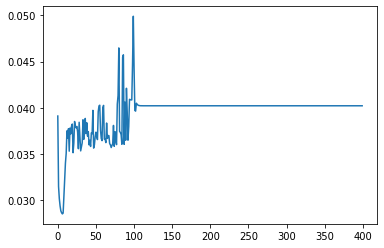

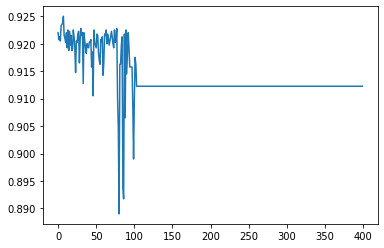

In [111]:
mlp=MLP(NInput=2,NHidden=2,NLHidden=2,NOutput=1,alpha=0.02)
mlp.Train(train[:,[0,1]],train[:,2],400)

In [112]:
mlp.Test(test[:,[0,1]],test[:,2],out=True)

This Test Predict Wrong:  6
This Test Predict Wrong:  56
This Test Predict Wrong:  59
This Test Predict Wrong:  60
This Test Predict Wrong:  67
This Test Predict Wrong:  74
This Test Predict Wrong:  77
This Test Predict Wrong:  83
This Test Predict Wrong:  99
This Test Predict Wrong:  101
This Test Predict Wrong:  102
This Test Predict Wrong:  122
This Test Predict Wrong:  134
This Test Predict Wrong:  136
This Test Predict Wrong:  137
This Test Predict Wrong:  149
This Test Predict Wrong:  160
This Test Predict Wrong:  174
This Test Predict Wrong:  186
This Test Predict Wrong:  187
This Test Predict Wrong:  198
This Test Predict Wrong:  234
This Test Predict Wrong:  254
This Test Predict Wrong:  258
This Test Predict Wrong:  266
This Test Predict Wrong:  271
This Test Predict Wrong:  283
This Test Predict Wrong:  284
This Test Predict Wrong:  289
This Test Predict Wrong:  300
This Test Predict Wrong:  329
This Test Predict Wrong:  333
This Test Predict Wrong:  335
This Test Predict Wr

[0.03503502975718048, 0.924]